# Express Repot on LLoS

## Import Libraries

In [2]:
# Loading Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import chi2_contingency
from scipy import stats
import scipy.cluster.hierarchy


import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn import svm, model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_score, recall_score, auc,roc_curve, roc_auc_score, f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix




In [3]:
plt.rcParams['figure.dpi'] = 300

## Data

### Load Data

In [4]:
df = pd.read_csv('dataset.csv')

In [5]:
df.shape

(12489, 69)

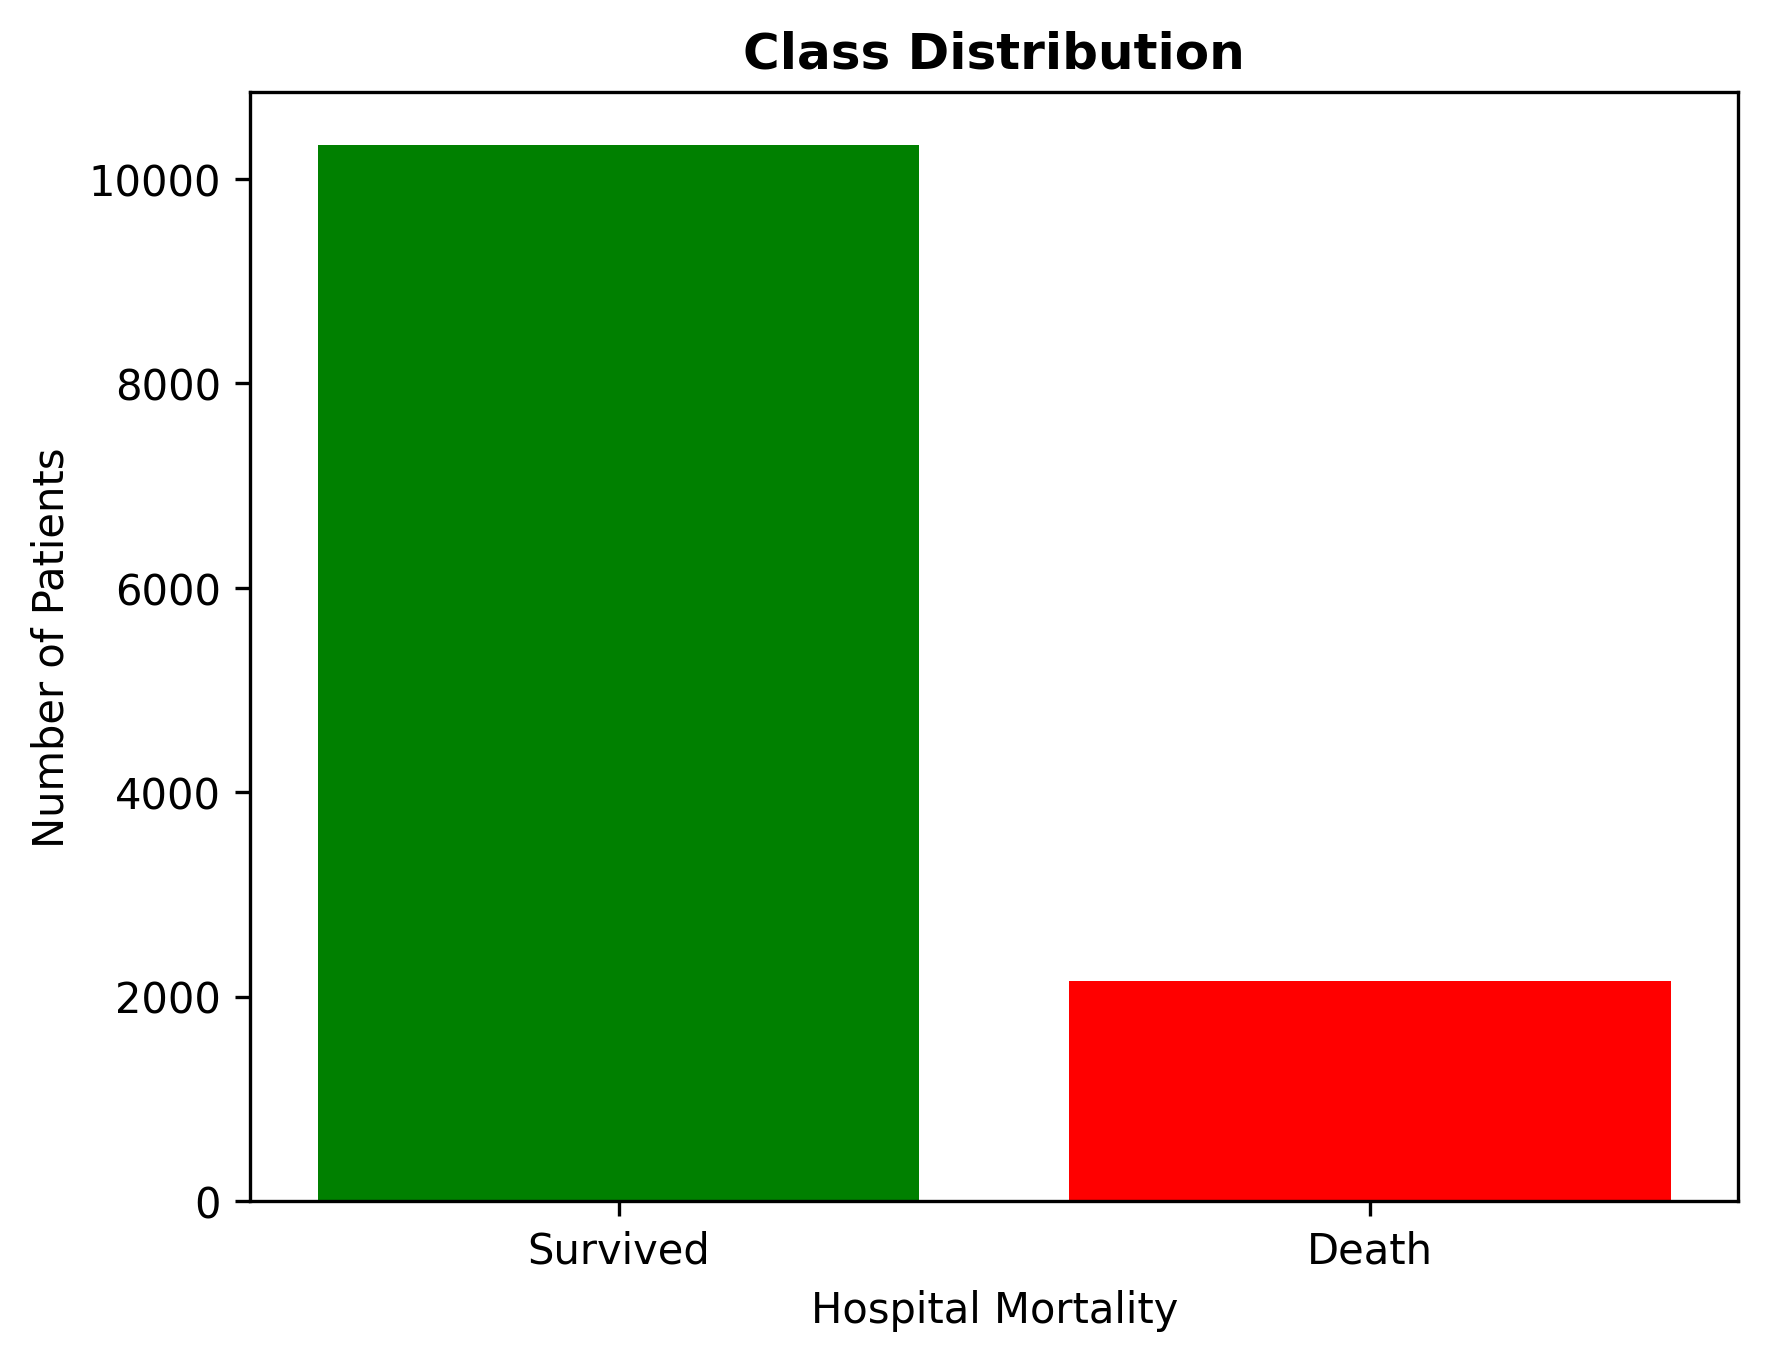

In [8]:
plt.bar(df['Hospital Mortality'].unique(), df['Hospital Mortality'].value_counts(), color = ['green', 'red'])
plt.xticks([0, 1], ['Survived', 'Death'])
plt.title('Class Distribution', weight = 'bold')
plt.xlabel('Hospital Mortality')
plt.ylabel('Number of Patients')
plt.show()

### Dependent & Independent variable

In [5]:
df['Gender'] = df['Gender'].replace({'M': 1, 'F': 0}).astype(int)
features = df.drop('Hospital Mortality', axis=1).columns
features = features[1::]
X = df[features]
y = df['Hospital Mortality']

C:\Users\JingH\AppData\Local\Temp\ipykernel_28192\1160885126.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace({'M': 1, 'F': 0}).astype(int)


### Training and Test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## the Baseline model

In [7]:
# the classifier is the XGBoost classifier
model = xgb.XGBClassifier(random_state=123)

# xgb = xgb.XGBClassifier(random_state=123)
# rf = RandomForestClassifier(random_state=123)
# svc = SVC(random_state=123, probability=True)

In [8]:
# Model Training
model = model.fit(X_train, y_train)

# Get Prediction Values
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

# Model Accuracy, how often is the classifier correct?
print("baseline model Accuracy:",metrics.accuracy_score(y_test, y_pred))

baseline model Accuracy: 0.8572191086202295


In [9]:
y_test.unique()

array([0, 1], dtype=int64)

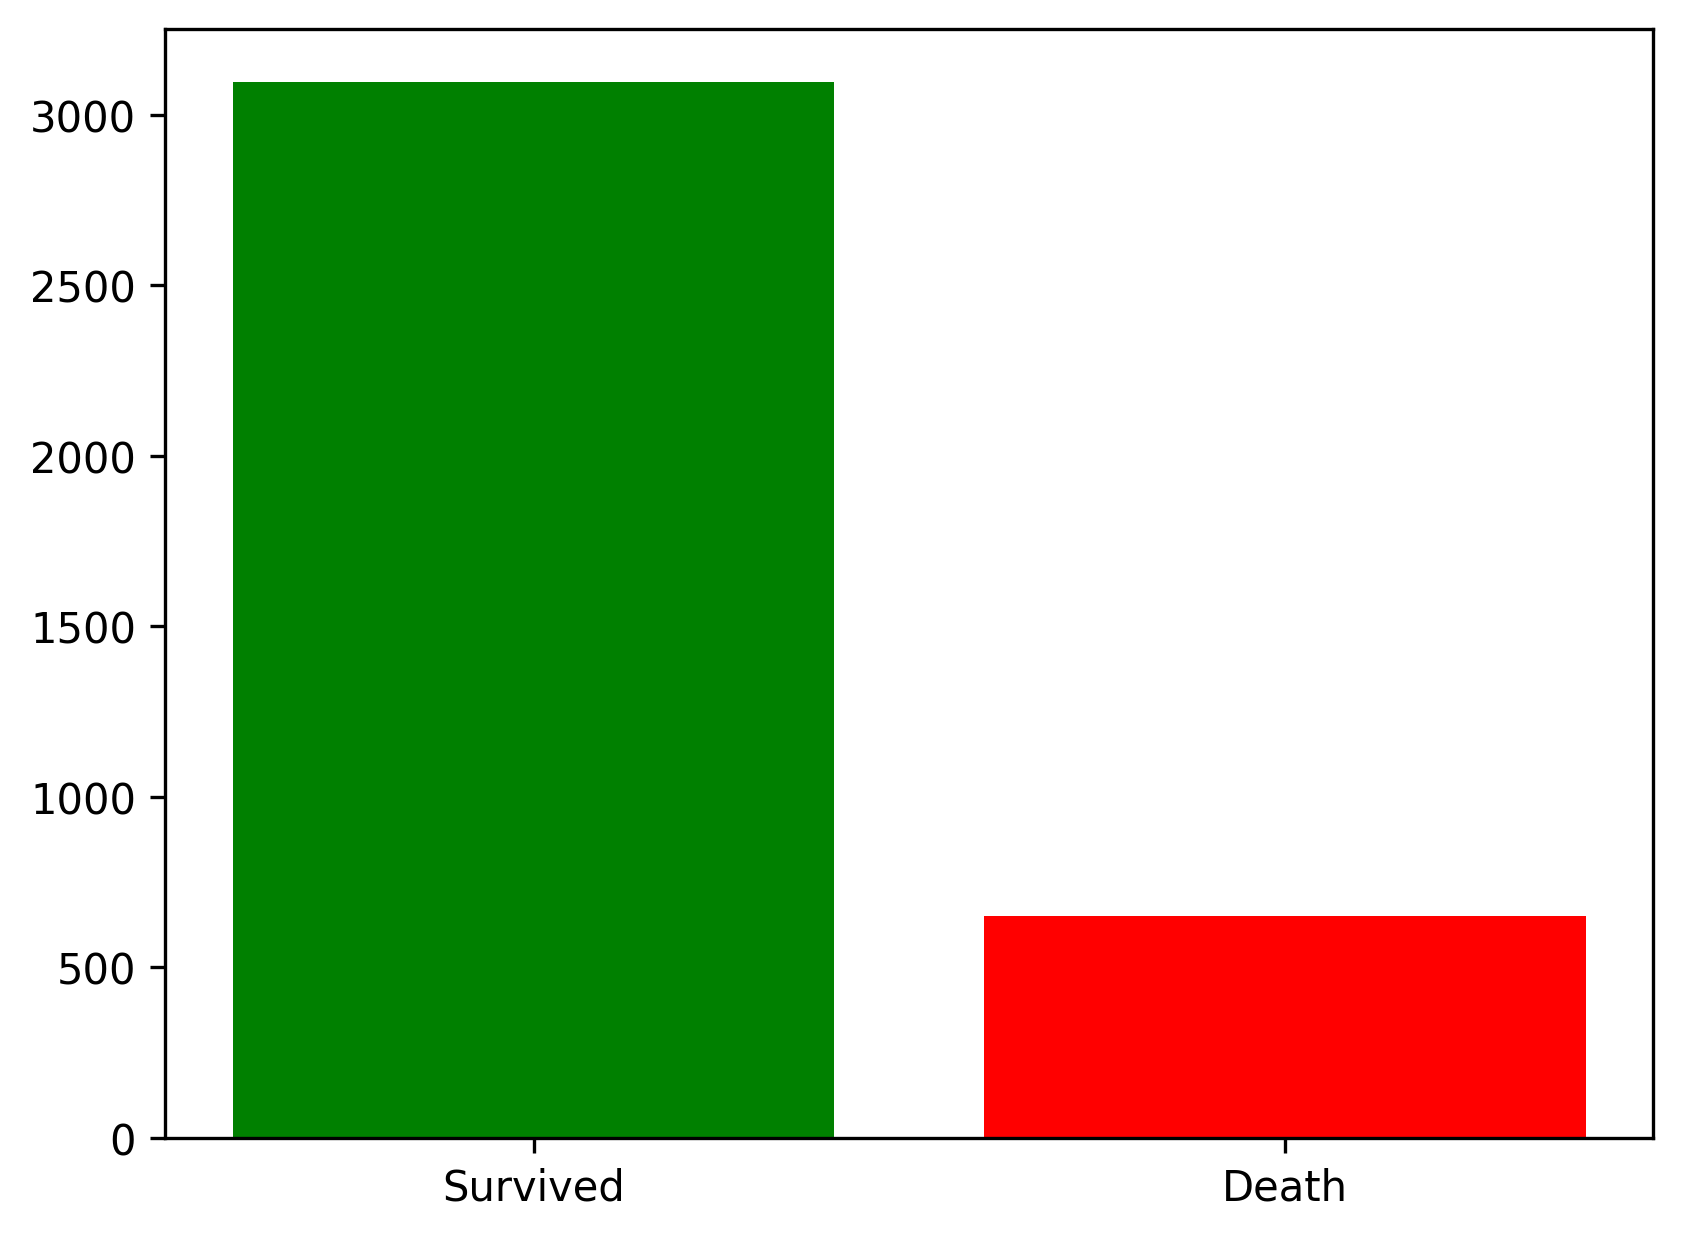

In [10]:
plt.bar(y_test.unique(), y_test.value_counts(), color = ['green', 'red'])
plt.xticks([0, 1], ['Survived', 'Death'])
plt.show()

## Random Under Sampler

In [11]:
rus = RandomUnderSampler(random_state=42)

In [12]:
# Undersampling the train set
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)

y_train_rus.value_counts()

Hospital Mortality
0    1508
1    1508
Name: count, dtype: int64

In [13]:
#Undersampling the test set
X_test_rus, y_test_rus= rus.fit_resample(X_test, y_test)

y_test_rus.value_counts()

Hospital Mortality
0    650
1    650
Name: count, dtype: int64

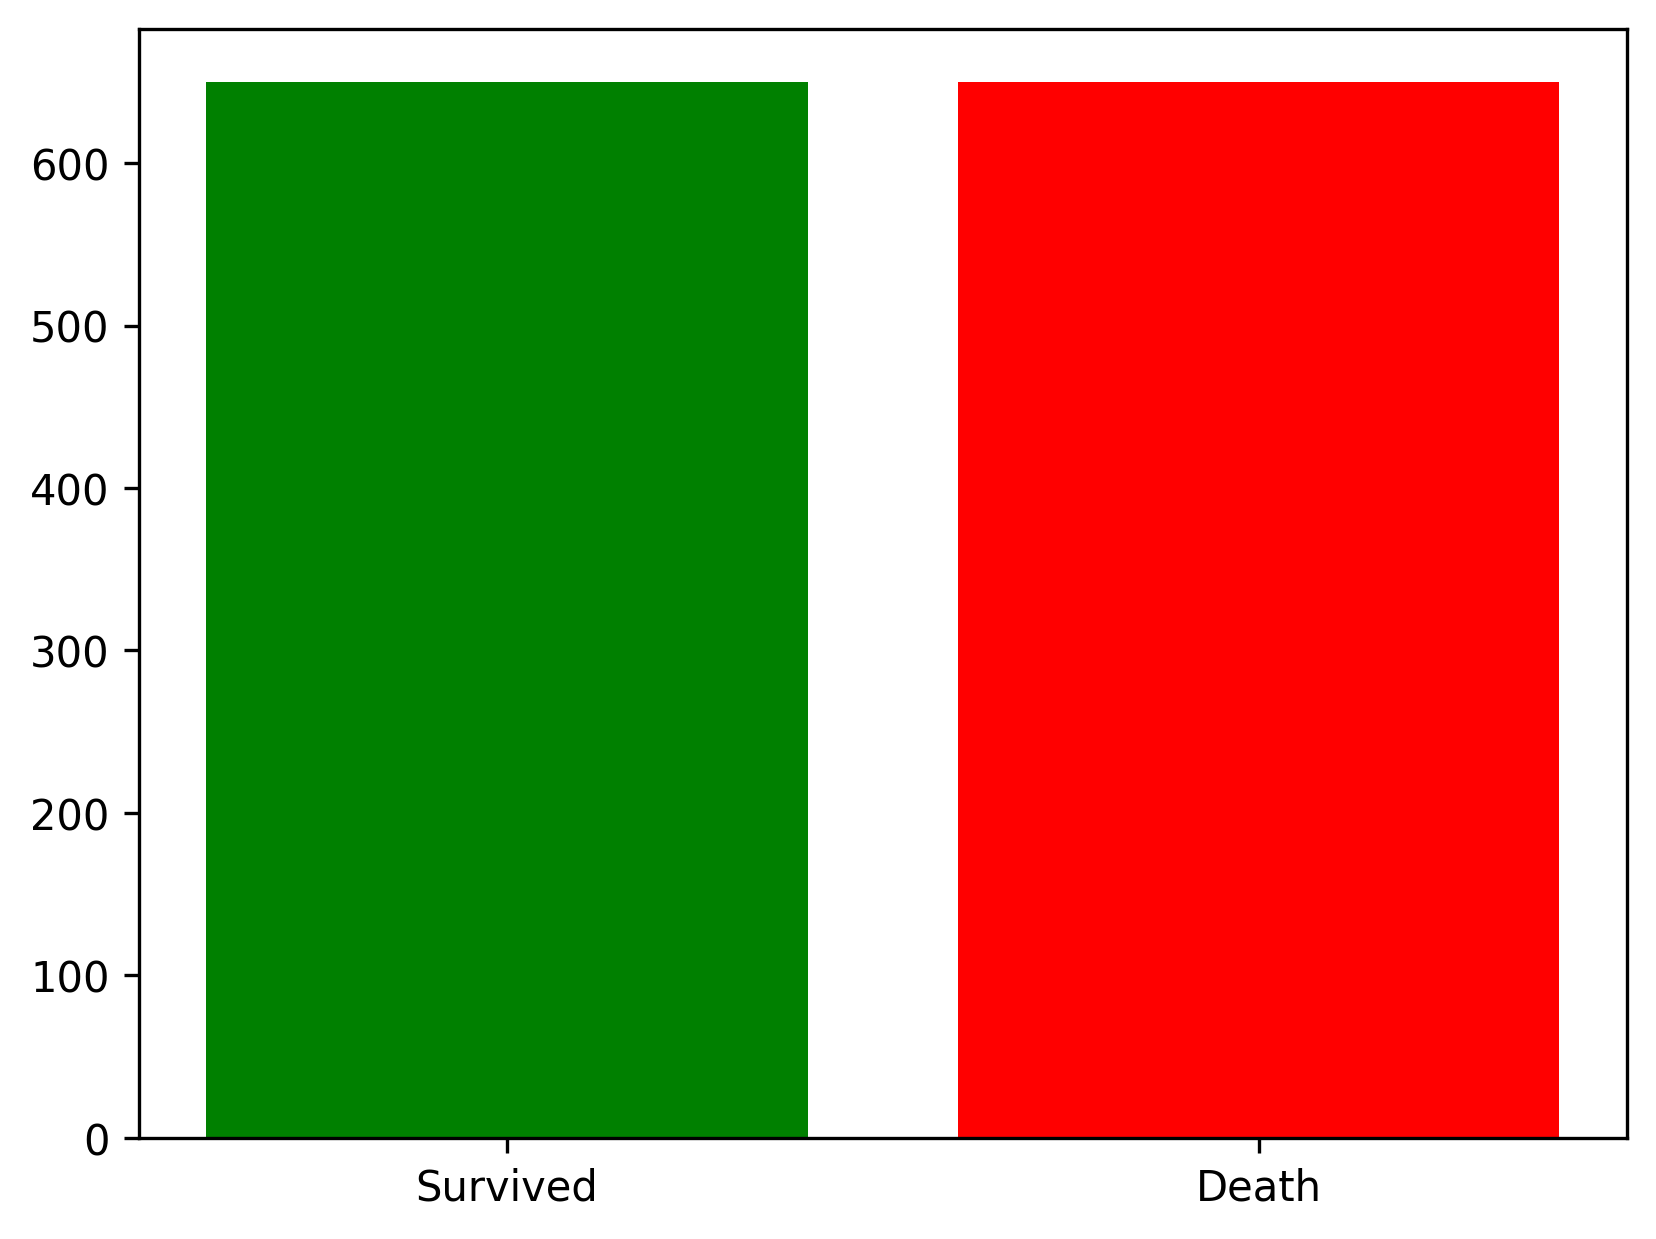

In [14]:
plt.bar(y_test_rus.unique(), y_test_rus.value_counts(), color = ['green', 'red'])
plt.xticks([0, 1], ['Survived', 'Death'])
plt.show()

### Classification report

In [15]:
# Fit the model with the undersampled training set
model.fit(X_train_rus, y_train_rus)

# Make predictions on the test set
y_pred = model.predict(X_test_rus)

# Evaluate the model
# Under Sampling Classification Reports
print("Classification Report: Baseline Model - Under Sampling")
print(classification_report(y_test_rus, y_pred, target_names = ['Survival', 'Death']))

Classification Report: Baseline Model - Under Sampling
              precision    recall  f1-score   support

    Survival       0.79      0.77      0.78       650
       Death       0.77      0.80      0.79       650

    accuracy                           0.78      1300
   macro avg       0.78      0.78      0.78      1300
weighted avg       0.78      0.78      0.78      1300



In [16]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test_rus, y_pred))

Accuracy: 0.7823076923076923


### ROC-AUC

In [17]:
y_prob = model.predict_proba(X_test_rus)
y_prob_rus = model.predict_proba(X_test_rus)

In [18]:
# AUC score
rus_auc = roc_auc_score(y_test_rus, y_prob_rus[:,1])
print(f"For the best models: \nBalanced Data AUC = {rus_auc}")

For the best models: 
Balanced Data AUC = 0.8589798816568046


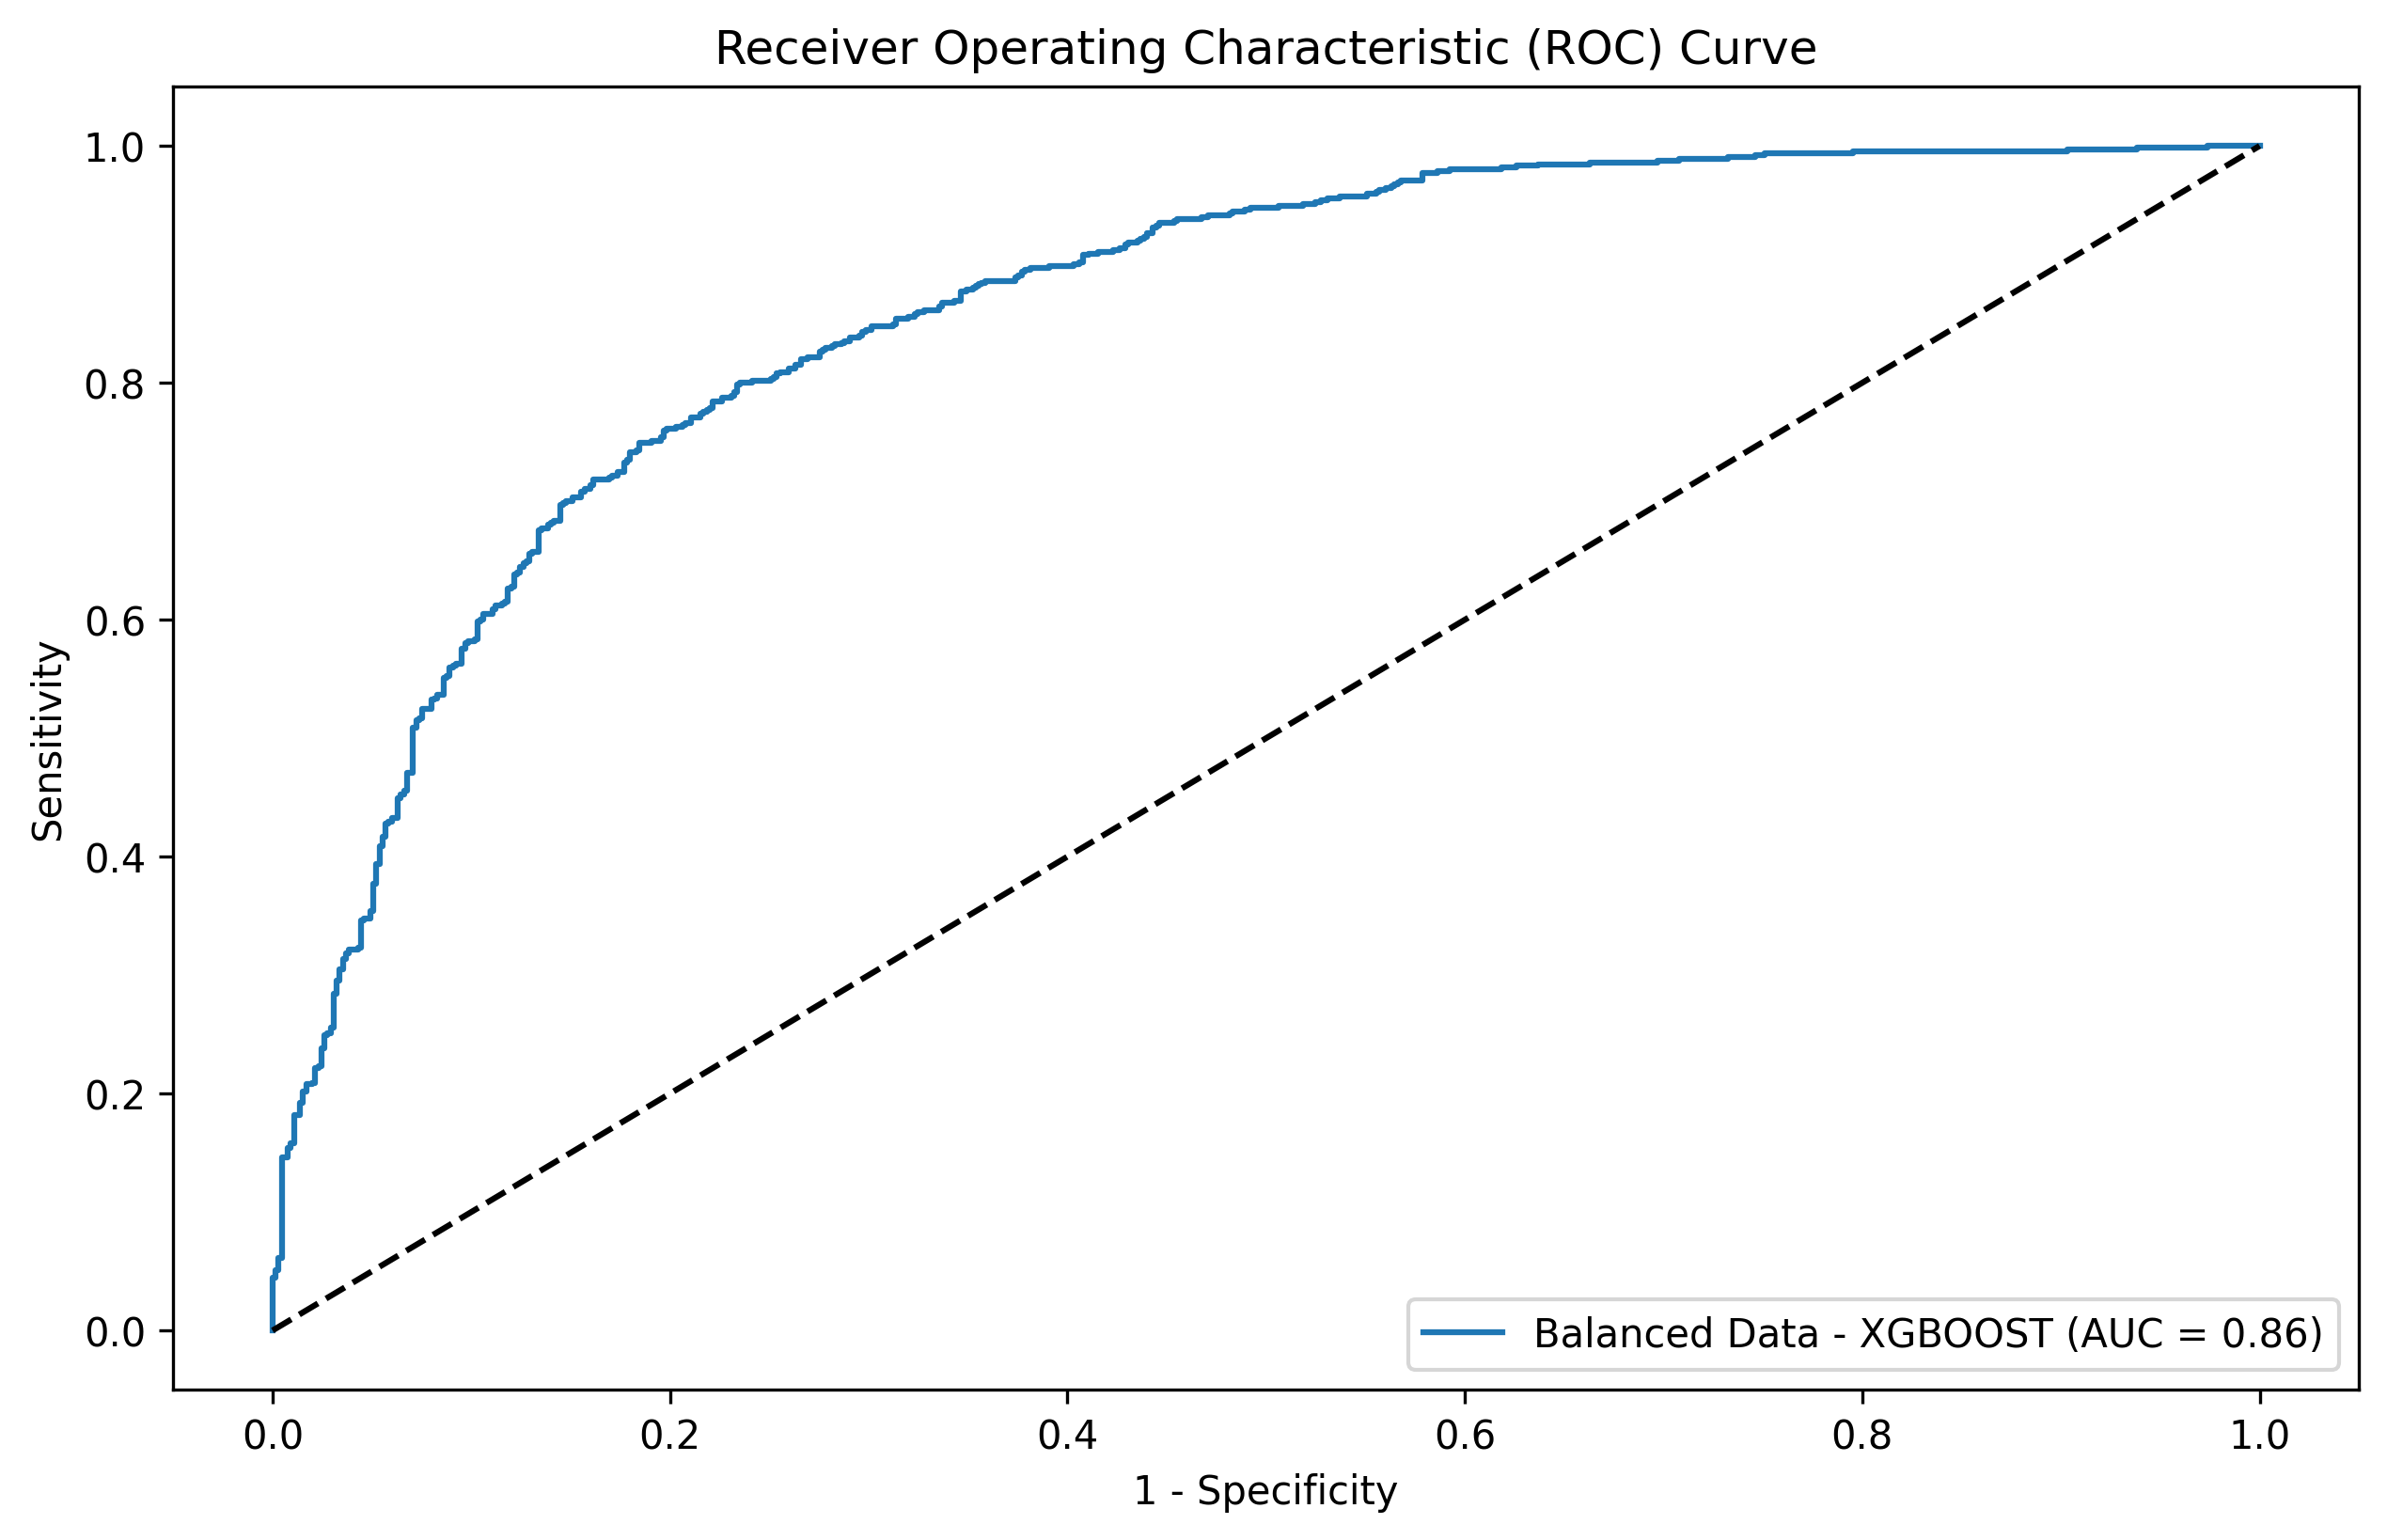

In [19]:
# Undersampling - AUC scores
# fpr - false positive rate
# tpr - true positive rate
# threshold - part of the decision function used to calculate fpr and tpr

fpr_rus, tpr_rus, threshold_rus = roc_curve(y_test_rus, y_prob_rus[:,1])


plt.figure(figsize = (10, 6))

plt.plot(fpr_rus, tpr_rus, label = f'Balanced Data - XGBOOST (AUC = {rus_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line representing random classifier

plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')

plt.show()

### Confusion Matrix

Text(0, 0.5, 'Actual')

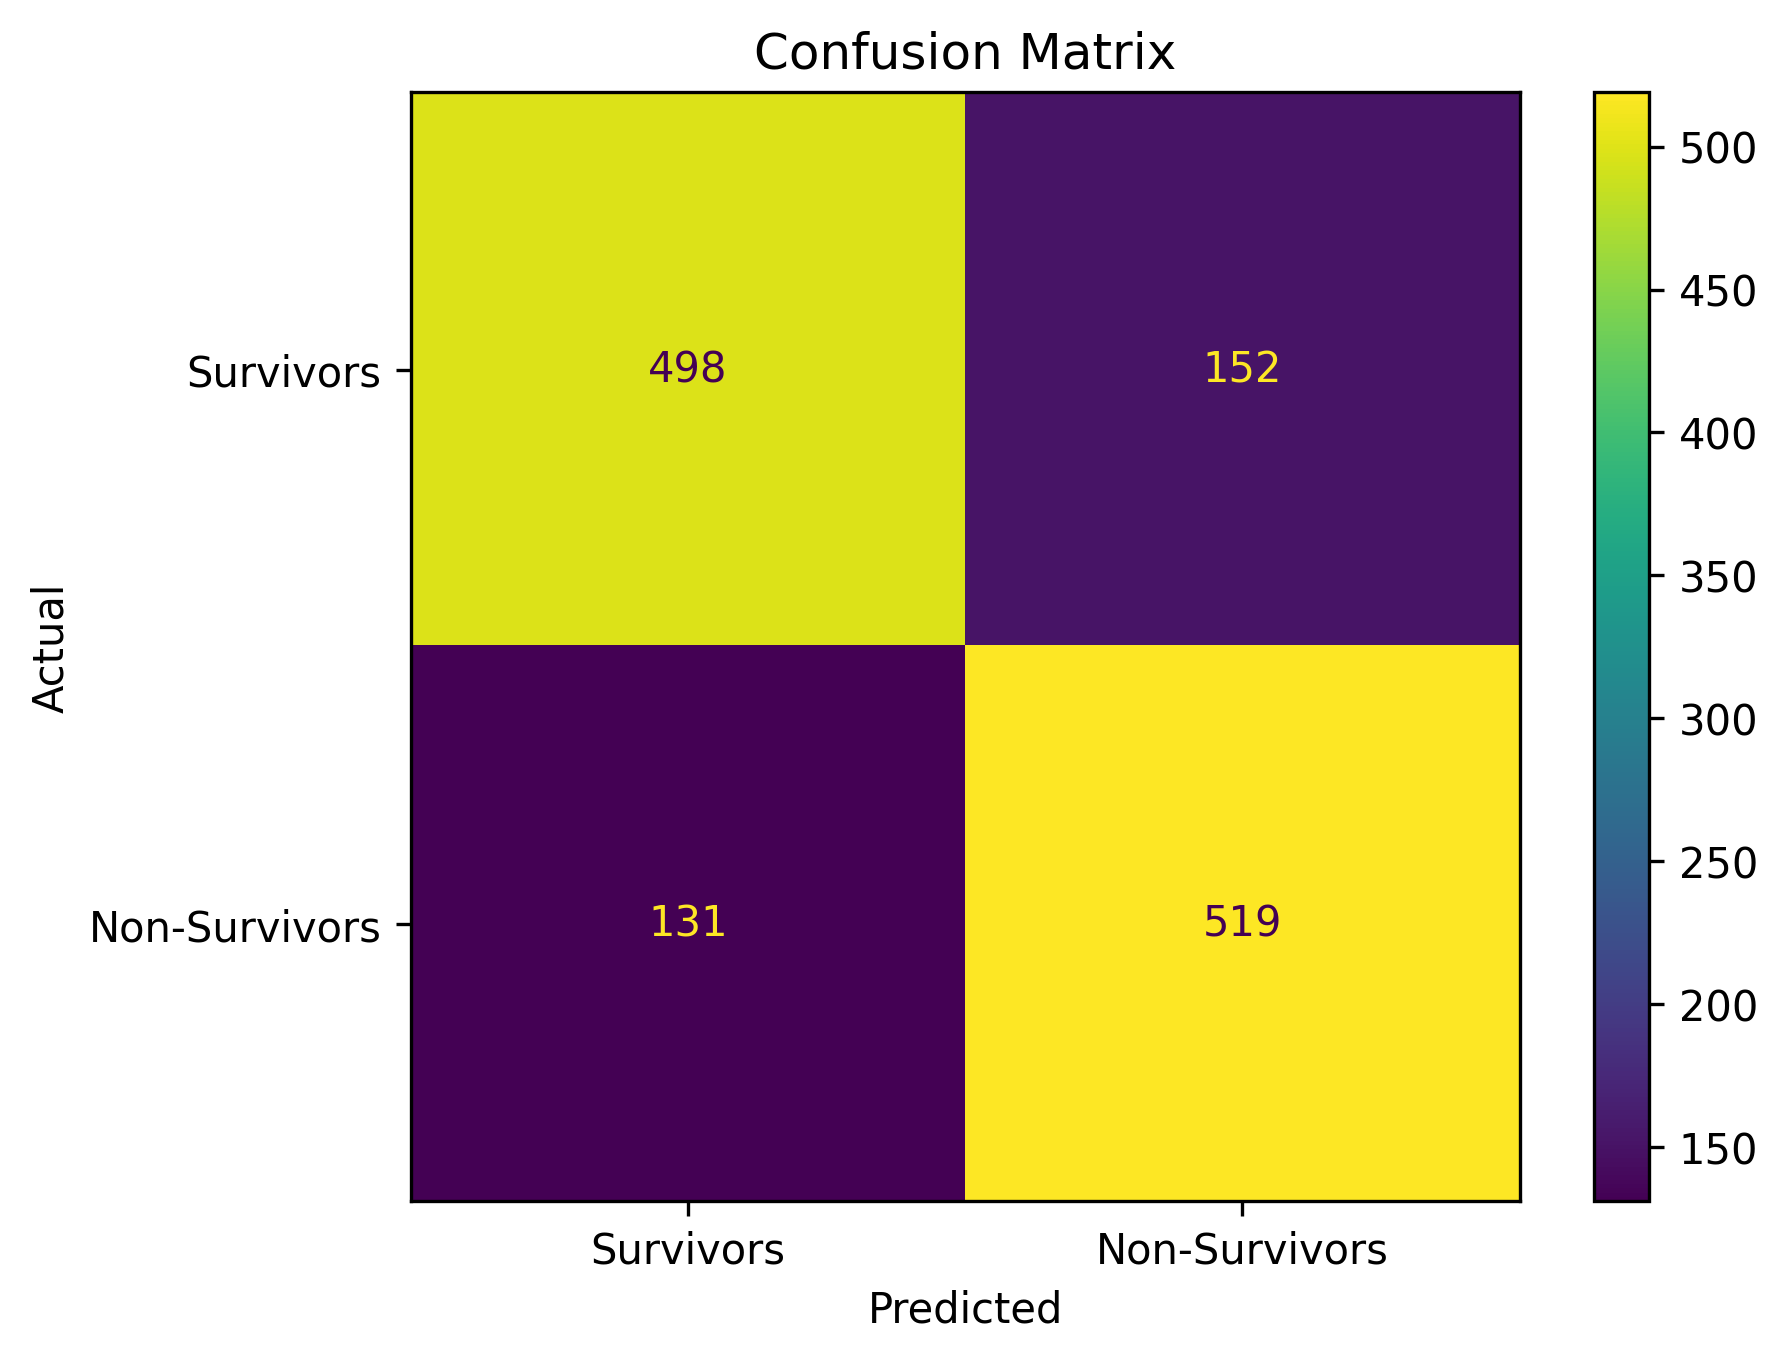

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_rus, y_pred)

# Plot the confusion matrix using ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
cmd.plot()

# Set title
cmd.ax_.set_title('Confusion Matrix')

# Set x and y tick labels
cmd.ax_.set_xticklabels(['Survivors', 'Non-Survivors'])
cmd.ax_.set_yticklabels(['Survivors', 'Non-Survivors'])

# Set x and y lable
cmd.ax_.set_xlabel('Predicted')
cmd.ax_.set_ylabel('Actual')

## Random Over Sampler

In [21]:
ros = RandomOverSampler(random_state=42)

In [22]:
# Undersampling the train set
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

y_train_ros.value_counts()

Hospital Mortality
0    7234
1    7234
Name: count, dtype: int64

In [23]:
#Undersampling the test set
X_test_ros, y_test_ros= ros.fit_resample(X_test, y_test)

y_test_ros .value_counts()

Hospital Mortality
0    3097
1    3097
Name: count, dtype: int64

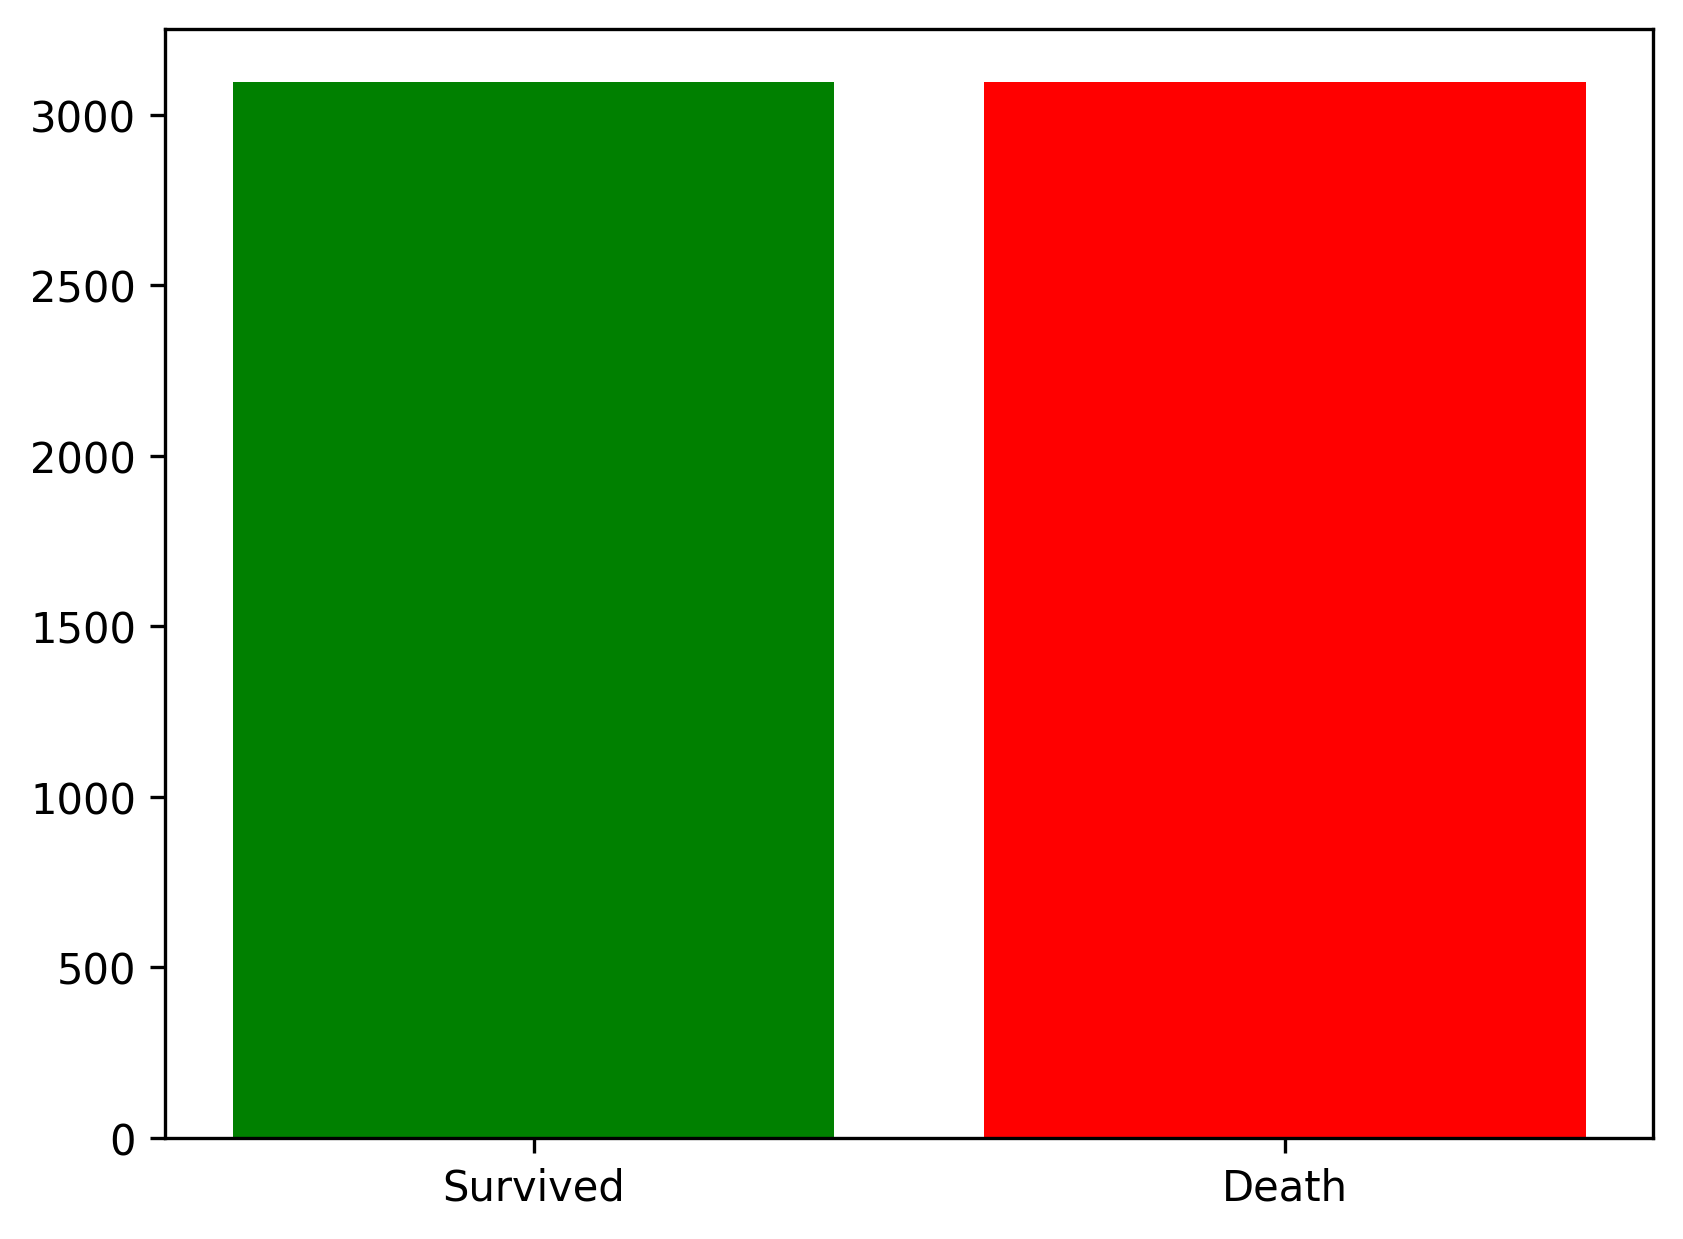

In [24]:
plt.bar(y_test_ros.unique(), y_test_ros.value_counts(), color = ['green', 'red'])
plt.xticks([0, 1], ['Survived', 'Death'])
plt.show()

### Classification report

In [25]:
# Fit the model with the undersampled training set
model.fit(X_train_ros, y_train_ros)

# Make predictions on the test set
y_pred = model.predict(X_test_ros)

# Evaluate the model
# Under Sampling Classification Reports
print("Classification Report: Baseline Model - UP Sampling")
print(classification_report(y_test_ros, y_pred, target_names = ['Survival', 'Death']))

Classification Report: Baseline Model - UP Sampling
              precision    recall  f1-score   support

    Survival       0.65      0.91      0.76      3097
       Death       0.85      0.50      0.63      3097

    accuracy                           0.71      6194
   macro avg       0.75      0.71      0.69      6194
weighted avg       0.75      0.71      0.69      6194



In [26]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test_ros, y_pred))

Accuracy: 0.7060058120762028


### ROC-AUC

In [27]:
y_prob = model.predict_proba(X_test_ros)
y_prob_ros = model.predict_proba(X_test_ros)

In [28]:
# AUC score
rus_auc = roc_auc_score(y_test_ros, y_prob_ros[:,1])
print(f"For the best models: \nBalanced Data AUC = {rus_auc}")

For the best models: 
Balanced Data AUC = 0.8505307197305422


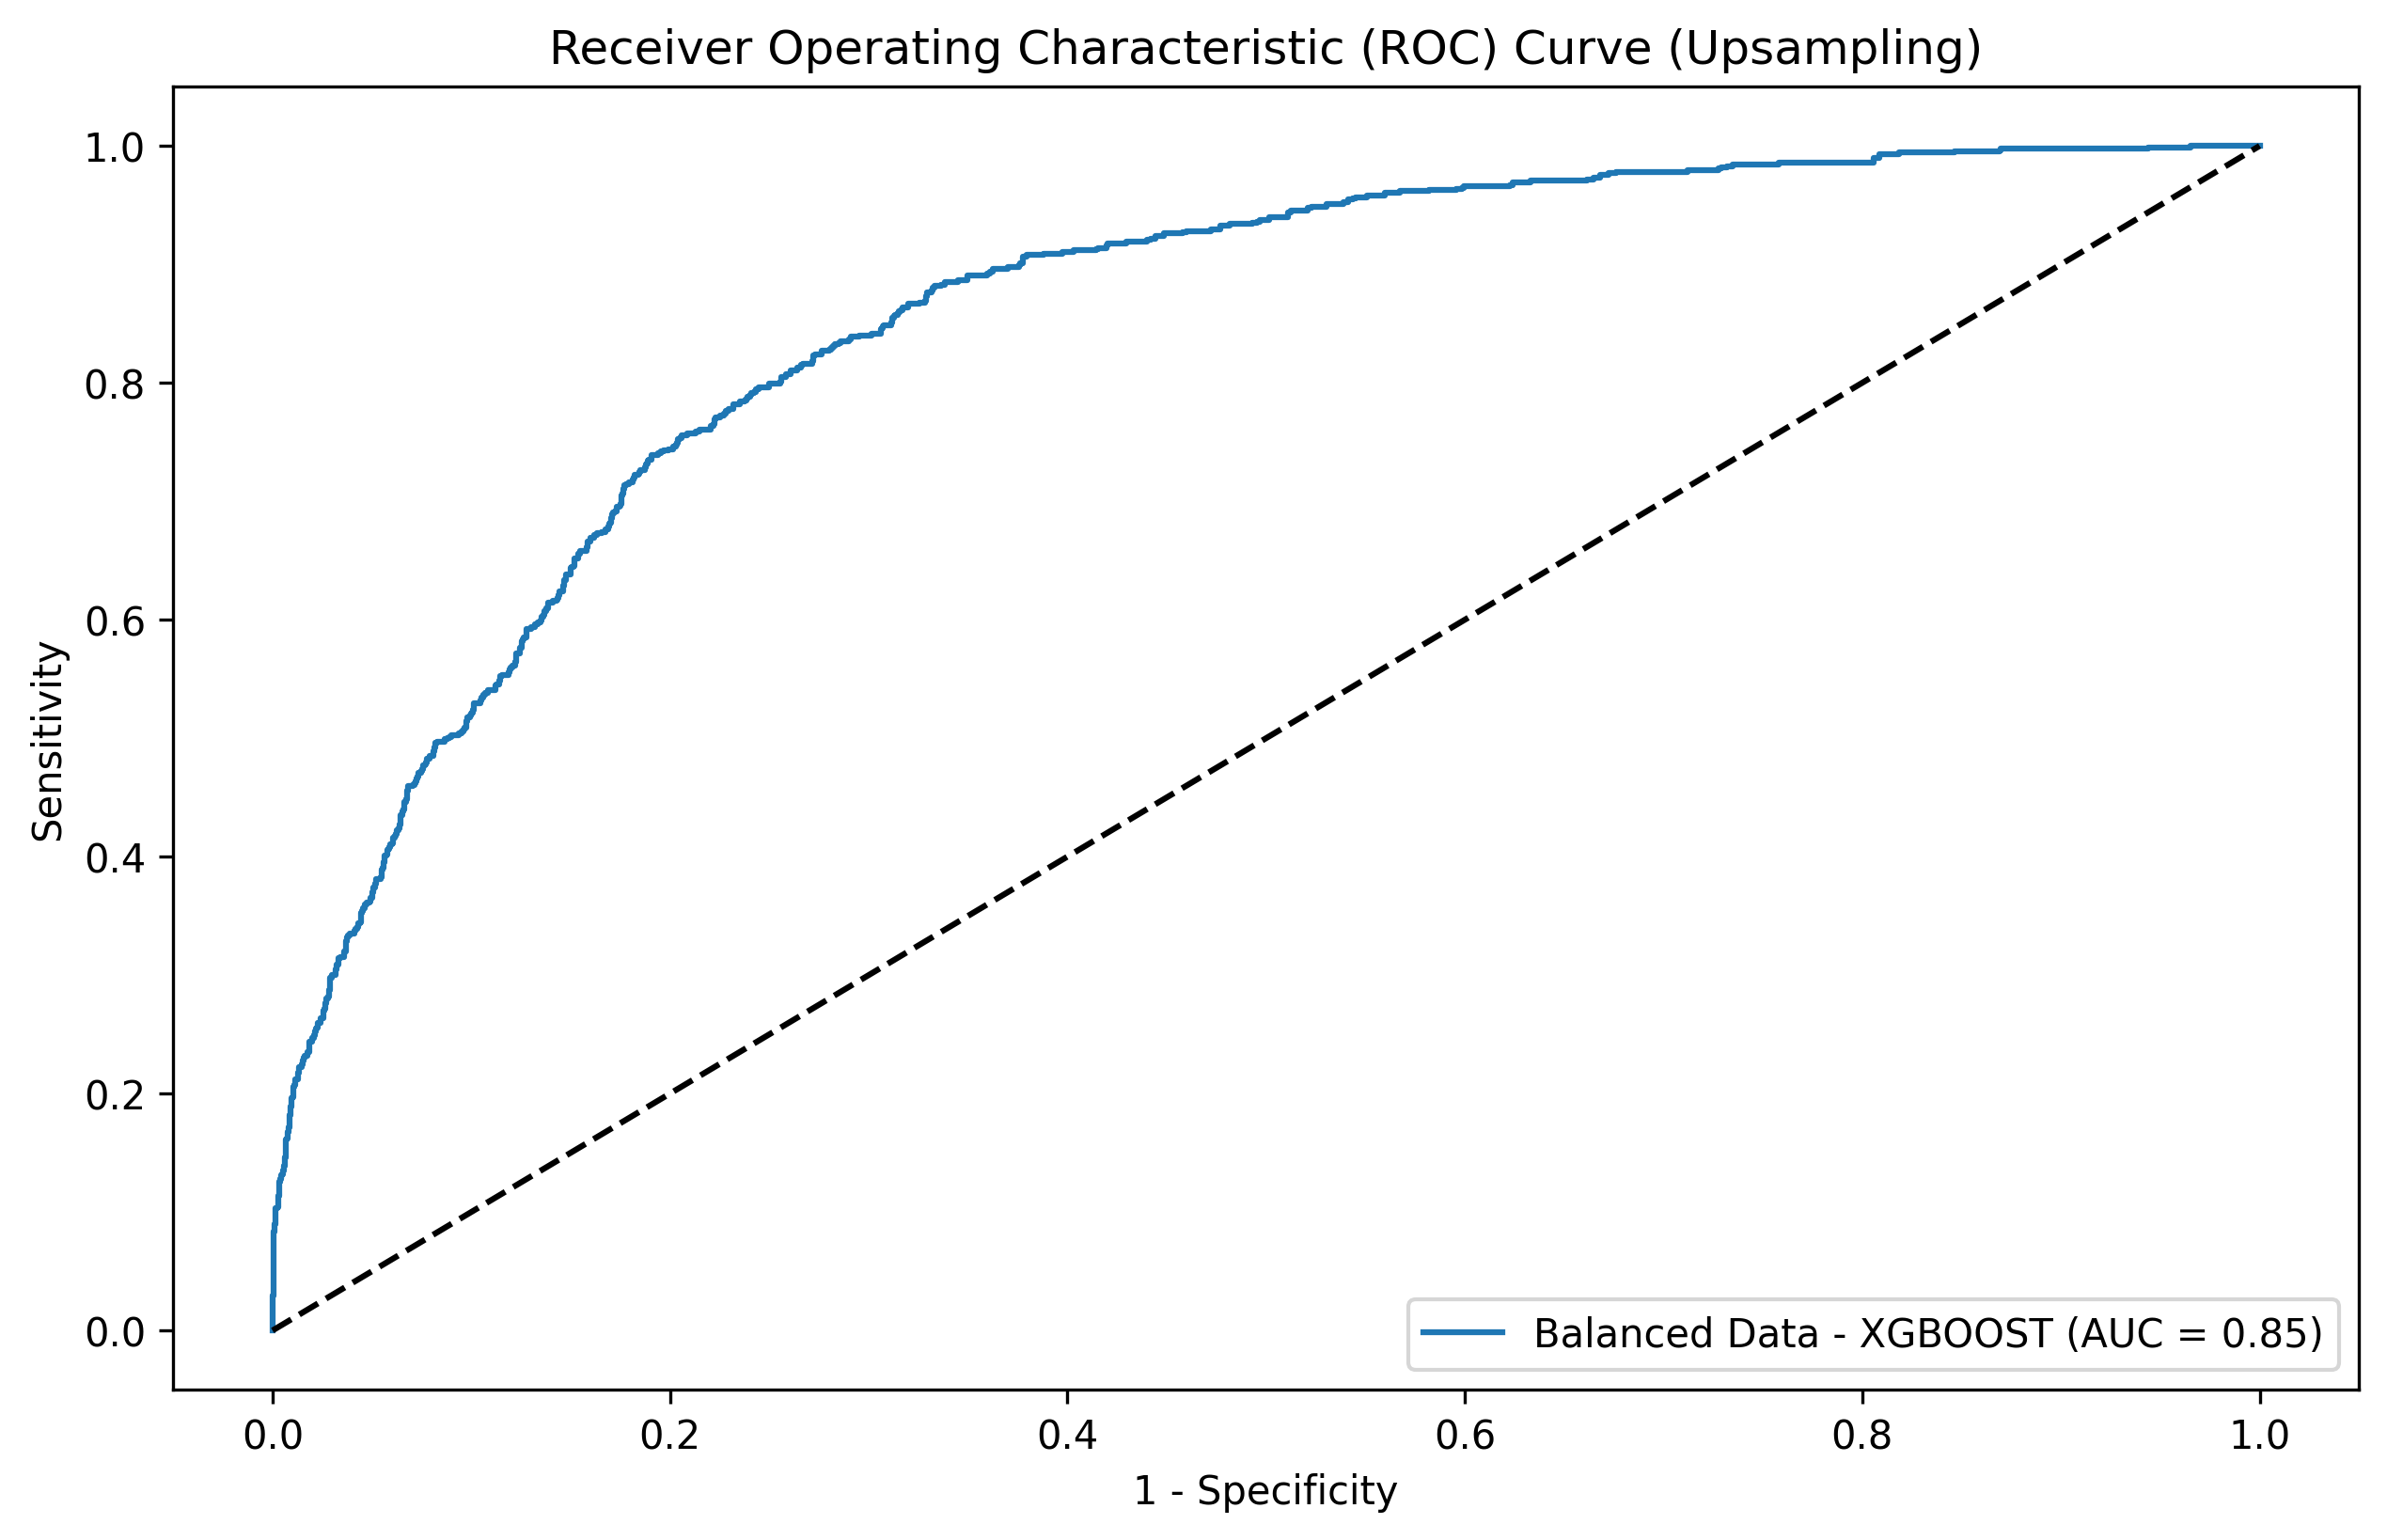

In [29]:
# Undersampling - AUC scores
# fpr - false positive rate
# tpr - true positive rate
# threshold - part of the decision function used to calculate fpr and tpr

fpr_ros, tpr_ros, threshold_rus = roc_curve(y_test_ros, y_prob_ros[:,1])


plt.figure(figsize = (10, 6))

plt.plot(fpr_ros, tpr_ros, label = f'Balanced Data - XGBOOST (AUC = {rus_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line representing random classifier

plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic (ROC) Curve (Upsampling)')
plt.legend(loc = 'lower right')

plt.show()

### Confusion Matrix

Text(0, 0.5, 'Actual')

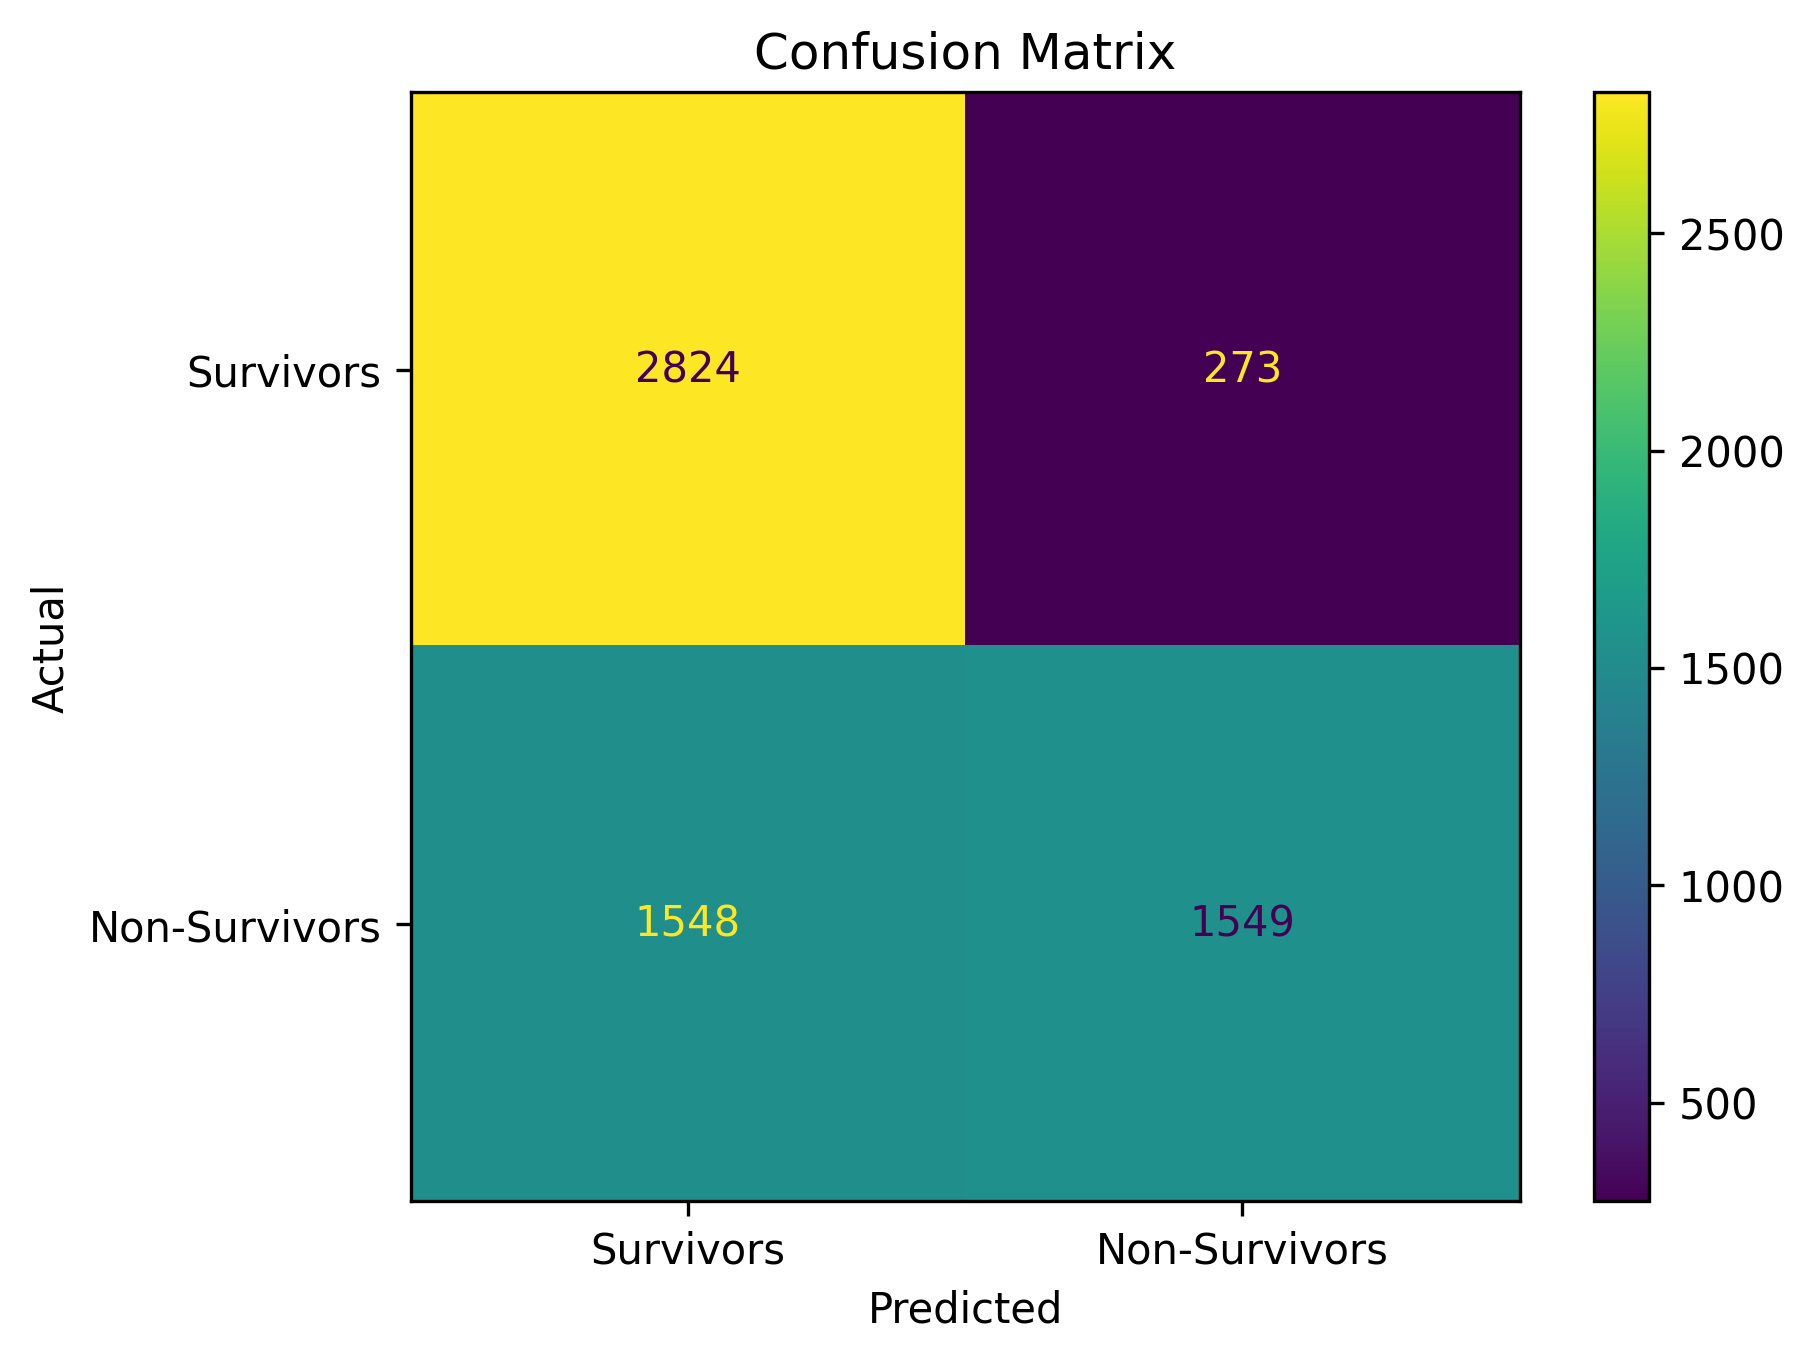

In [30]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_ros, y_pred)

# Plot the confusion matrix using ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
cmd.plot()

# Set title
cmd.ax_.set_title('Confusion Matrix')

# Set x and y tick labels
cmd.ax_.set_xticklabels(['Survivors', 'Non-Survivors'])
cmd.ax_.set_yticklabels(['Survivors', 'Non-Survivors'])

# Set x and y lable
cmd.ax_.set_xlabel('Predicted')
cmd.ax_.set_ylabel('Actual')